# Headline Analysis

We have 2 news headline datasets,
1. data/News_Category_Dataset_v3.json 
    - HuffPost
    - 210,294 records between 2012 and 2022
    - Attributes: (category, headline, authors, link, short_description, date)
2. data/abcnews-date-text.csv 
    - Australian ABC
    - 1,103,665 records between 2003 and 2021
    - Attributes: (headline, date)

1) First we will work on the Australian ABC dataset and do a Kmeans clustering, we will look at the clusters and see what type of news headline it is. (Use reference/k-means-clustering...)

2) Second we will work on the HuffPost dataset which has a category attribute. We will then make a model predicting a headlines category (forget about authors, link short description and date). (Use reference/nlp-news-articles...)

3) Third we will use the model in 2 to predict the headlines in 1 and compare the models predictions with the Kmeans categroy it's put in

4) Future Possibilities
-   Sentiment analysis and prediction on each of the categories (kmeans category and predifined categories)
-   Talk about real world utilization of Headline analysis (stock market prediction etc)
    -   If a headline mentions a company and is in the business category we can use the sentiment to 'skim' the idea
-   Use the time attributes of the headlines to predict the categroy of news on a certain day
-   Do a correlation report between the clusters by finding the closest cluster means to a data point

### (1) K-means 

In [1]:
import sys
!{sys.executable} -m pip install numpy matplotlib scikit-learn scipy seaborn nltk

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

Prepping data by deleting duplicate headlines to avoid giving kmeans clustering higher weighted datapoints

In [6]:
data = pd.read_csv("../data/abcnews-date-text.csv", usecols =["headline_text"])
data = data[data['headline_text'].duplicated(keep=False)].drop_duplicates('headline_text')

data.head(5)

,headline_text
151,resource stocks boost all ords
320,man in hospital after stabbing attack
322,man on murder charge refused bail
351,oil prices hit new high
360,pilot makes emergency landing at adelaide airport


Vectorization of the data for NLP.

In [9]:
# Punctiation to separate words for vecotrization
punctuation = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
# Words that are uninformative like 'and' 'or' 'but' 
stop_words = text.ENGLISH_STOP_WORDS.union(punctuation)

desc = data['headline_text'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)

X = vectorizer.fit_transform(desc)

# Show some sample words that areextracted from the vecotrization
features = vectorizer.get_feature_names()
print(len(features))
print(features[100:200])

7473
['aaa', 'aaco', 'aamer', 'aaron', 'ab', 'abalone', 'abares', 'abattoir', 'abbot', 'abbott', 'abbotts', 'abc', 'abcnews', 'abcs', 'abduction', 'abductions', 'abercrombie', 'abeysinghes', 'ablett', 'aboard', 'aboriginal', 'aborted', 'abs', 'abu', 'aburizal', 'abuse', 'abusing', 'accc', 'accents', 'access', 'accident', 'accidents', 'accounts', 'accuse', 'accused', 'accuses', 'accy', 'aceh', 'acknowledge', 'acland', 'acoss', 'acquired', 'acquit', 'acquitted', 'acropolis', 'act', 'actew', 'action', 'activist', 'activity', 'ad', 'adam', 'adani', 'adapting', 'addresses', 'adds', 'adelaide', 'adjourned', 'admits', 'adoptions', 'adrian', 'adriana', 'adrienne', 'ads', 'advance', 'advances', 'adventure', 'adverse', 'adversity', 'advised', 'advisor', 'aerials', 'aerosol', 'affair', 'affairs', 'affected', 'affecting', 'afford', 'affordability', 'affordable', 'afghan', 'afghanistan', 'afl', 'africa', 'afridi', 'aftermath', 'ag', 'agar', 'age', 'aged', 'agencies', 'agenda', 'agm', 'ago', 'agree'

Stemming words. Combining words that are all related like 'read' 'reading' etc. Token breaks the sentence into the words and punctiation.

In [13]:
# Use predefined stemmers and tokenizers
stem = SnowballStemmer('english')
token = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    # Returns the array of stemmed words from the tokenized text
    return [stem.stem(word) for word in token.tokenize(text.lower())]

vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()

# Can see there are almost 1500 words that are stemmed into other words
print(len(word_features2))
print(word_features2[:50]) 

# Compressed tokenizer into only 1000 stem words
vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)
words = vectorizer3.get_feature_names()

6069
['aaa', 'aaco', 'aamer', 'aaron', 'ab', 'abalon', 'abar', 'abattoir', 'abbot', 'abbott', 'abc', 'abcnew', 'abduct', 'abercrombi', 'abeysingh', 'ablett', 'aboard', 'aborigin', 'abort', 'abov', 'abu', 'aburiz', 'abus', 'accc', 'accent', 'access', 'acci', 'accid', 'account', 'accus', 'aceh', 'acknowledg', 'acland', 'acoss', 'acquir', 'acquit', 'acropoli', 'act', 'actew', 'action', 'activ', 'activist', 'ad', 'adam', 'adani', 'adapt', 'add', 'address', 'adelaid', 'adjourn']


Kmeans useing the elbow method. We could also do the silloette method

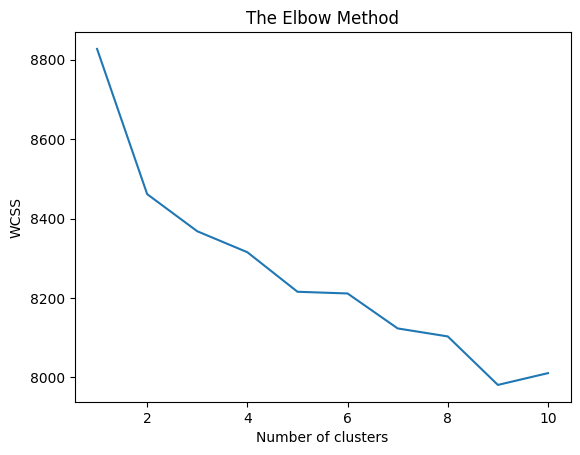

In [19]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

8 looks like a good choice

In [20]:
kmeans = KMeans(n_clusters = 8,n_init = 20)
kmeans.fit(X3)
# Finally, we look at 8 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : interview, extend, nrl, michael, mark, luke, andrew, jame, ben, afl, john, matt, chris, daniel, steve, paul, nathan, david, scott, peter, adam, matthew, josh, nick, smith
1 : man, media, charg, crash, kill, miss, die, court, murder, speak, busi, news, interview, car, new, rate, search, continu, report, australia, accus, sydney, australian, win, warn
2 : polic, probe, investig, miss, man, hunt, crash, search, fatal, victim, seek, wit, car, bandit, road, death, assault, driver, pursuit, charg, offic, arm, shoot, teen, plead
3 : woman, hous, die, miss, charg, stab, car, crash, blaze, elder, polic, man, price, murder, kill, famili, hit, search, hospit, fatal, escap, fear, court, bodi, burn
4 : grandstand, breakfast, august, juli, march, novemb, decemb, septemb, june, april, octob, stump, februari, januari, day, tuesday, tv, rod, tasmania, canberra, act, sport, sa, thursday, south
5 : market, share, close, local, higher, lower, wednesday, australian, tuesday, monday, bank, friday, wrap,

Breakdown

0) Celebrity interview
1) Local news
2) Criminal news
3) More criminal news
4) Months
5) Finance and markets
6) Weird one with days of the week
7) Sports